# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

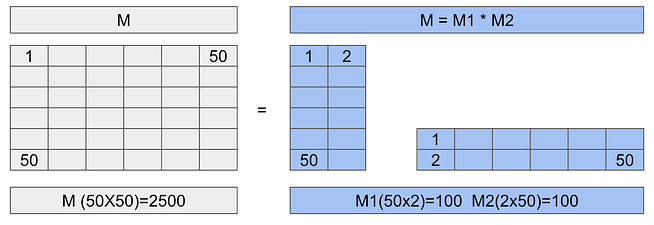

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [ ]:
#!pip install -q peft==0.8.2
#!pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

In [ ]:
#pip uninstall -y gcsfs fsspec

In [ ]:
#pip install datasets==2.16.1 fsspec[http]==2023.10.0 gcsfs==2023.10.0

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [5]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        num_beams=1,  # Enable beam search for better quality
        do_sample=True,  # Enable sampling
        temperature=0.7,  # Control randomness
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [6]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach. You need someone who is willing and able, not afraid or discouraged.\nYou may ask me why I am doing this? Your brain needs your work out so that it can feel good about its ability while also giving yourself some extra time over the course']


# *Results obtained from the first run of Inference Original Model:*

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
['I want you to act as a motivational coach. You will be able to:\n• Develop and implement strategies for improving your performance, including: • Motivating yourself;']

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
['I want you to act as a motivational coach. You will be able to:\n• Develop and implement strategies for improving your performance, including: • Motivating yourself;']

In [ ]:
# Below is a recomended code to improve quality of the original model without tunning
'''
# Tokenize the input prompt
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt")

# Generate outputs with refined generation parameters
foundational_outputs_sentence = foundation_model.generate(
    input_ids=input_sentences["input_ids"],
    attention_mask=input_sentences["attention_mask"],
    max_new_tokens=100,  # Limit the maximum number of new tokens
    repetition_penalty=1.5,  # Penalize repeated words or phrases
    early_stopping=True,  # Stop if an <eos> token is found
    num_beams=5  # Enable beam search for better quality generation
)

# Decode the generated tokens into text and skip special tokens
decoded_output = tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True)

# Print the generated text
print(decoded_output)'''

'''Code tested refer to below output printed:

['I want you to act as a motivational coach. I want you to be a leader.
I want you to be a mentor. I want you to be a teacher. I want you to be a doctor.
 I want you to be a lawyer. I want you to be a politician. I want you to be a scientist.
 I want you to be a mathematician. I want you to be a physicist.
 I want you to be a mathematician. I want you to be a physicist.
 I want you to be a mathematician']'''


['I want you to act as a motivational coach. I want you to be a leader. I want you to be a mentor. I want you to be a teacher. I want you to be a doctor. I want you to be a lawyer. I want you to be a politician. I want you to be a scientist. I want you to be a mathematician. I want you to be a physicist. I want you to be a mathematician. I want you to be a physicist. I want you to be a mathematician']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [7]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [8]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

In [9]:
print(train_sample[:5]) # Display the first 5 samples for verification

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.', "Using WebPilot, create an outline for an article that will be 2,000 words on the keyword 'Best SEO prompts' based on the top 10 results from Google. Include every relevant heading possible. Keep the keyword density of the headings high. For each section of the outline, include the word count. Include FAQs section in the outline too, based on people also ask section from Google for the keyword. This out

In [10]:
# Convert the dataset to a pandas DataFrame for easier visualization
import pandas as pd
df = pd.DataFrame(train_sample)
print(df.head())

                                              prompt  \
0  Imagine you are an experienced Ethereum develo...   
1  Using WebPilot, create an outline for an artic...   
2  I want you to act as a linux terminal. I will ...   
3  I want you to act as an English translator, sp...   
4  I want you to act as an interviewer. I will be...   

                                           input_ids  \
0  [186402, 1152, 1306, 660, 72560, 28857, 167625...   
1  [39312, 15202, 51, 46712, 15, 7932, 660, 67606...   
2  [44, 4026, 1152, 427, 1769, 661, 267, 104105, ...   
3  [44, 4026, 1152, 427, 1769, 661, 660, 7165, 24...   
4  [44, 4026, 1152, 427, 1769, 661, 660, 33322, 2...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..

In [11]:
max_length = max(len(ids) for ids in train_sample["input_ids"])
print(f"Maximum token length: {max_length}")

Maximum token length: 168


In [12]:
##Check token length:
##Check how many tokens the longest prompts have,
#to decide if you need to truncate or split them.

# Calculate the length of each prompt in tokens
df['token_length'] = df['input_ids'].apply(len)

# Check the longest prompts
print(df['token_length'].describe())
print(df[df['token_length'] > 512])  # Example for models with 512-token limits

count     50.000000
mean      94.440000
std       16.503753
min       72.000000
25%       85.000000
50%       89.000000
75%      103.750000
max      168.000000
Name: token_length, dtype: float64
Empty DataFrame
Columns: [prompt, input_ids, attention_mask, token_length]
Index: []


# **Token Length Validation Results**
Summary Statistics:

1. Tokens per Prompt:

- Mean: 94.44 tokens.

- Max: 168 tokens.

- Min: 72 tokens.

- The token lengths are fairly consistent, with a standard deviation of ~16.5.

2. Long Prompts (more than 512 tokens):

- No examples exceed the 512 token limit.

- The check df[df['token_length'] > 512] returned an empty DataFrame, confirming that all samples fit within the model’s limits.

This ensures that the dataset is within the typical limits for most language models, avoiding the need for truncation.

Interpretation:

Prepared dataset: There are no excessively long prompts, so there is no need to truncate or split inputs.

Efficiency: With relatively short prompts (maximum 160 tokens), the model should process them efficiently during training.

# Fine-Tuning.
First is necesary create a LoRA config.


In [13]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [14]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 466,944 || all params: 559,607,808 || trainable%: 0.0834
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [15]:
#Create a directory to contain the Model
import os
working_dir = '/content/drive/MyDrive/Ironhack/Lora_Tunning_PEFT'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [16]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=False,
    report_to="none"
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [ ]:
#!pip install -U peft transformers

In [23]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False) #This is the recommended data collator by Huggingface
)

# Define a custom loss function that accepts num_items_in_batch
def compute_loss(model, inputs, return_outputs=False, num_items_in_batch=None): # Added num_items_in_batch
    outputs = model(**inputs)
    return (outputs.loss, outputs) if return_outputs else outputs.loss

# Override the compute_loss method of the Trainer instance
trainer.compute_loss = compute_loss


trainer.train()

Step,Training Loss


TrainOutput(global_step=14, training_loss=2.9514427185058594, metrics={'train_runtime': 11.1715, 'train_samples_per_second': 8.951, 'train_steps_per_second': 1.253, 'total_flos': 21871163621376.0, 'train_loss': 2.9514427185058594, 'epoch': 2.0})

In [24]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [25]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [26]:
import torch

# Ensure the model and inputs are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=3072, bias=False)
                )
                (lora_e

In [27]:
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a motivational coach. My first request is "I need help making students feel more accountable for their efforts in achieving specific goals and objectives", I will use my answers carefully designed tests that are helpful both at the end of each session but also before they move on with new learning']


# **Metrics**

In [28]:
# Example prompts and expected outputs
prompts = [
    "I want you to act as a motivational coach.",
    "Give me advice on achieving my career goals.",
    "How can I improve my public speaking skills?"
]

# Ground truth responses (expected outputs)
expected_responses = [
    "As a motivational coach, I recommend setting clear goals, staying positive, and practicing daily.",
    "To achieve your career goals, set milestones, network with others, and continuously learn.",
    "Improve public speaking by practicing regularly, seeking feedback, and observing skilled speakers."
]

In [29]:
generated_responses = []

for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = loaded_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=50,
        num_beams=5,  # Using beam search for better quality
        early_stopping=True
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_responses.append(response)

# Print generated responses for review
for i, response in enumerate(generated_responses):
    print(f"Prompt: {prompts[i]}")
    print(f"Generated Response: {response}\n")


Prompt: I want you to act as a motivational coach.
Generated Response: I want you to act as a motivational coach. My first request is "I need some help finding motivation in my life." My first request is "I need help finding motivation in my work." My first request is "I need help finding motivation in my work." My first request is "I need help

Prompt: Give me advice on achieving my career goals.
Generated Response: Give me advice on achieving my career goals. My first request is "I need you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you

Prompt: How can I improve my public speaking skills?
Generated Response: How can I improve my public speaking skills? The you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you



In [ ]:
#!pip install evaluate

In [31]:
#BLUE Metric Calculation

from evaluate import load

# Load BLEU metric
bleu = load("bleu")

# Compute BLEU score
bleu_results = bleu.compute(predictions=generated_responses, references=[[resp] for resp in expected_responses])
print("BLEU Score:", bleu_results["bleu"])

BLEU Score: 0.0


In [ ]:
#!pip install rouge_score

In [33]:
#Rouge Metric Calculation

# Load ROUGE metric
rouge = load("rouge")

# Compute ROUGE scores
rouge_results = rouge.compute(predictions=generated_responses, references=expected_responses)
print("ROUGE Scores:", rouge_results)


ROUGE Scores: {'rouge1': 0.0971020150755278, 'rouge2': 0.050234988086650494, 'rougeL': 0.09710201507552779, 'rougeLsum': 0.0971020150755278}


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

# **EXP01: Experiments with model "bigscience/bloom-560m"**

In [34]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_exp01 = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_exp01)
foundation_model = AutoModelForCausalLM.from_pretrained(model_exp01)

In [49]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=50): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,
        num_beams=5,  # Enable beam search for better quality
        do_sample=True,  # Enable sampling
        temperature=0.7,  # Control randomness
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id # End-of-sequence token
    )
    return outputs

In [36]:
#Preparing the Dataset

from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data_exp01 = load_dataset(dataset)
data_exp01 = data_exp01.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample_exp01 = data_exp01["train"].select(range(200))

train_sample_exp01 = train_sample_exp01.remove_columns('act')

display(train_sample_exp01)

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [37]:
print(train_sample_exp01[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

In [38]:
print(train_sample_exp01[:5])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.', "Using WebPilot, create an outline for an article that will be 2,000 words on the keyword 'Best SEO prompts' based on the top 10 results from Google. Include every relevant heading possible. Keep the keyword density of the headings high. For each section of the outline, include the word count. Include FAQs section in the outline too, based on people also ask section from Google for the keyword. This out

In [39]:
#Fine-Tuning

# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config_exp01 = LoraConfig(
    r=8, #As bigger the R bigger the parameters to train. changed 4=>8
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix.
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.2, #Helps to avoid Overfitting. changed 0.05=>0.1 #changed 0.1=>0.2 for exp#02
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

In [40]:
#Create the PEFT model.

peft_model_exp01 = get_peft_model(foundation_model, lora_config_exp01)
print(peft_model.print_trainable_parameters())

trainable params: 73,728 || all params: 559,607,808 || trainable%: 0.0132
None


In [55]:
print(peft_model_exp01.print_trainable_parameters())

trainable params: 73,728 || all params: 560,001,024 || trainable%: 0.0132
None


In [41]:
#Create a directory to contain the Model
import os
working_dir = '/content/drive/MyDrive/Ironhack/Lora_Tunning_PEFT'

output_directory_exp01 = os.path.join(working_dir, "peft_lab_outputs_exp01")

In [42]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args_exp01 = TrainingArguments(
    output_dir=output_directory_exp01,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate=5e-3 , # Higher learning rate than full fine-tuning. #changed 3e-2=>5e-3 for exp#02 Reduced for a more stable training process
    num_train_epochs=50,#changed 2=>1 #changed 1=>3 for exp#02 Increase for mor learning #changed 3=>50 for exp#03
    use_cpu=False,
    report_to="none"
)

In [44]:
#Train

#This cell may take up to 15 minutes to execute.
trainer_exp01 = Trainer(
    model=peft_model_exp01,
    args=training_args_exp01,
    train_dataset=train_sample_exp01,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Define a custom loss function that accepts num_items_in_batch
def compute_loss(model, inputs, return_outputs=False, num_items_in_batch=None): # Added num_items_in_batch
    outputs = model(**inputs)
    return (outputs.loss, outputs) if return_outputs else outputs.loss

# Override the compute_loss method of the Trainer instance
trainer_exp01.compute_loss = compute_loss

trainer_exp01.train()

Step,Training Loss


Step,Training Loss
500,5.508800
1000,10.732600
1500,11.573300
2000,12.384000
2500,12.769400


TrainOutput(global_step=2500, training_loss=10.59362646484375, metrics={'train_runtime': 1220.5382, 'train_samples_per_second': 8.193, 'train_steps_per_second': 2.048, 'total_flos': 2651976247246848.0, 'train_loss': 10.59362646484375, 'epoch': 50.0})

In [45]:
#Save the model.
peft_model_path_exp01 = os.path.join(output_directory_exp01, f"lora_model_exp01")

trainer_exp01.model.save_pretrained(peft_model_path_exp01)

In [46]:
#Load the Model.
loaded_model_exp01 = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path_exp01,
                                        is_trainable=False)

In [47]:
import torch

# Ensure the model and inputs are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model_exp01.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.2, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_em

In [50]:
#Inference the fine-tuned model.

# Prepare the input sentence and move it to the same device as the model
input_sentences_exp01 = tokenizer("I want you to act as a motivational coach.", return_tensors="pt").to(device)

# Generate output using the fine-tuned model
foundational_outputs_sentence_exp01 = get_outputs(loaded_model_exp01, input_sentences_exp01, max_new_tokens=50)

# Decode and print the generated response
print(tokenizer.batch_decode(foundational_outputs_sentence_exp01, skip_special_tokens=True))

['I want you to act as a motivational coach. pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr']


In [51]:
# Example prompts and expected outputs
prompts_exp01 = [
    "I want you to act as a motivational coach.",
    "Give me advice on achieving my career goals.",
    "How can I improve my public speaking skills?"
]

# Ground truth responses (expected outputs)
expected_responses_exp01 = [
    "As a motivational coach, I recommend setting clear goals, staying positive, and practicing daily.",
    "To achieve your career goals, set milestones, network with others, and continuously learn.",
    "Improve public speaking by practicing regularly, seeking feedback, and observing skilled speakers."
]

In [52]:
generated_responses_exp01 = []

for prompt in prompts_exp01:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = loaded_model_exp01.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=50,
        num_beams=5,  # Using beam search for better quality
        early_stopping=True
    )
    response_exp01 = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_responses_exp01.append(response_exp01)

# Print generated responses for review
for i, response_exp01 in enumerate(generated_responses_exp01):
    print(f"Prompt: {prompts_exp01[i]}")
    print(f"Generated Response: {response_exp01}\n")


Prompt: I want you to act as a motivational coach.
Generated Response: I want you to act as a motivational coach. pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr pr

Prompt: Give me advice on achieving my career goals.
Generated Response: Give me advice on achieving my career goals. and and and and and and and and and and and and and and and and and and and and and and first first first first first first first first first first first first first first first first first first first first first first first first first first first first

Prompt: How can I improve my public speaking skills?
Generated Response: How can I improve my public speaking skills? and and and and and up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up up



In [53]:
#BLUE Metric Calculation

from evaluate import load

# Load BLEU metric
bleu = load("bleu")

# Compute BLEU score
bleu_results_exp01 = bleu.compute(predictions=generated_responses_exp01, references=[[resp] for resp in expected_responses_exp01])
print("BLEU Score:", bleu_results_exp01["bleu"])

BLEU Score: 0.0


In [54]:
#Rouge Metric Calculation

# Load ROUGE metric
rouge = load("rouge")

# Compute ROUGE scores
rouge_results_exp01 = rouge.compute(predictions=generated_responses_exp01, references=expected_responses_exp01)
print("ROUGE Scores:", rouge_results_exp01)


ROUGE Scores: {'rouge1': 0.11192635263636615, 'rouge2': 0.04763477140192676, 'rougeL': 0.10279393254504195, 'rougeLsum': 0.10279393254504195}


# **EXP02: Experiments by optimizing model "bigscience/bloom-560m"**

In [56]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_exp02 = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_exp02)
foundation_model = AutoModelForCausalLM.from_pretrained(model_exp02)

In [57]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=50): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.2,# Reduced to limit excessive penalization
        num_beams=10,  # Increased for higher-quality generations
        do_sample=True,  # Enable sampling
        temperature=0.5,  # Reduced to balance randomness and repetition
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id # End-of-sequence token
    )
    return outputs

In [59]:
#Preparing the Dataset

from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data_exp02 = load_dataset(dataset)
data_exp02 = data_exp02.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample_exp02 = data_exp02["train"].select(range(203))

train_sample_exp02 = train_sample_exp02.remove_columns('act')

display(train_sample_exp02)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 203
})

In [60]:
print(train_sample_exp02[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

In [61]:
print(train_sample_exp02[:5])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.', "Using WebPilot, create an outline for an article that will be 2,000 words on the keyword 'Best SEO prompts' based on the top 10 results from Google. Include every relevant heading possible. Keep the keyword density of the headings high. For each section of the outline, include the word count. Include FAQs section in the outline too, based on people also ask section from Google for the keyword. This out

In [62]:
#Fine-Tuning

# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config_exp02 = LoraConfig(
    r=16, #As bigger the R bigger the parameters to train. changed 8=>16 Increased for more parameters to train
    lora_alpha=0.5, # a scaling factor that adjusts the magnitude of the weight matrix.  # Reduced for finer adjustments 1=>0.5
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.1, #Helps to avoid Overfitting.  0.1=>0.2 changed #changed 0.2=>0.1 for exp#02
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

In [63]:
#Create the PEFT model.

peft_model_exp02 = get_peft_model(foundation_model, lora_config_exp02)
print(peft_model_exp02.print_trainable_parameters())

trainable params: 1,646,592 || all params: 560,787,456 || trainable%: 0.2936
None


In [64]:
#Create a directory to contain the Model
import os
working_dir = '/content/drive/MyDrive/Ironhack/Lora_Tunning_PEFT'

output_directory_exp02 = os.path.join(working_dir, "peft_lab_outputs_exp02")

In [65]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args_exp02 = TrainingArguments(
    output_dir=output_directory_exp02,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate=3e-4 , # Higher learning rate than full fine-tuning. #changed 3e-2=>5e-3 for exp#01 5e-3=>3e-4 for exp02
    num_train_epochs=100,#Increase for more learning changed 2=>50 for exp#01 changed 50=>100 for exp#02
    use_cpu=False,
    report_to="none"
)

In [66]:
#Train - This cell may take up to 15 minutes to execute.
trainer_exp02 = Trainer(
    model=peft_model_exp02,
    args=training_args_exp02,
    train_dataset=train_sample_exp02,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Define a custom loss function that accepts num_items_in_batch
def compute_loss(model, inputs, return_outputs=False, num_items_in_batch=None): # Added num_items_in_batch
    outputs = model(**inputs)
    return (outputs.loss, outputs) if return_outputs else outputs.loss

# Override the compute_loss method of the Trainer instance
trainer_exp02.compute_loss = compute_loss

trainer_exp02.train()

Step,Training Loss


Step,Training Loss


Step,Training Loss
500,2.744500
1000,2.603800
1500,2.626700
2000,2.636300
2500,2.678900
3000,2.672700
3500,2.649400
4000,2.648900
4500,2.614200
5000,2.599500


TrainOutput(global_step=10200, training_loss=2.5807017666685814, metrics={'train_runtime': 2254.774, 'train_samples_per_second': 9.003, 'train_steps_per_second': 4.524, 'total_flos': 4460804049002496.0, 'train_loss': 2.5807017666685814, 'epoch': 100.0})

In [67]:
#Save the model.
peft_model_path_exp02 = os.path.join(output_directory_exp02, f"lora_model_exp02")

trainer_exp02.model.save_pretrained(peft_model_path_exp02)

In [68]:
#Load the Model.
loaded_model_exp02 = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path_exp02,
                                        is_trainable=False)

In [69]:
import torch

# Ensure the model and inputs are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model_exp02.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_

In [70]:
#Inference the fine-tuned model.

# Prepare the input sentence and move it to the same device as the model
input_sentences_exp02 = tokenizer("I want you to act as a motivational coach.", return_tensors="pt").to(device)

# Generate output using the fine-tuned model
foundational_outputs_sentence_exp02 = get_outputs(loaded_model_exp02, input_sentences_exp02, max_new_tokens=50)

# Decode and print the generated response
print(tokenizer.batch_decode(foundational_outputs_sentence_exp02, skip_special_tokens=True))

['I want you to act as a motivational coach. I will provide you with some information related to my goals and objectives, and it will be your job to guide me through the steps I need to take to achieve them. This could involve providing advice on improving my work habits, improving my communication skills,']


In [71]:
# Example prompts and expected outputs
prompts_exp02 = [
    "Act as a motivational coach. Provide clear and actionable advice for overcoming challenges at work.",
    "What are the best strategies to set and achieve professional goals effectively?",
    "How can I build confidence and enhance my public speaking skills for high-pressure situations?"
]

# Ground truth responses (expected outputs)
expected_responses_exp02 = [
    "As a motivational coach, I recommend setting clear goals, staying positive, and practicing daily.",
    "To achieve your career goals, set milestones, network with others, and continuously learn.",
    "Improve public speaking by practicing regularly, seeking feedback, and observing skilled speakers."
]

In [76]:
generated_responses_exp02 = []

for prompt in prompts_exp02:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = loaded_model_exp02.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=100,  # Allow longer responses
        num_beams=5,  # Enable beam search
        temperature=0.8,  # Increase diversity
        repetition_penalty=2.5,  # Penalize repetitive outputs
        early_stopping=True,
        do_sample=True
    )
    response_exp02 = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_responses_exp02.append(response_exp02)

# Print generated responses for review
for i, response_exp02 in enumerate(generated_responses_exp02):
    print(f"Prompt: {prompts_exp02[i]}")
    print(f"Generated Response: {response_exp02}\n")


Prompt: Act as a motivational coach. Provide clear and actionable advice for overcoming challenges at work.
Generated Response: Act as a motivational coach. Provide clear and actionable advice for overcoming challenges at work. Develop strategies to motivate employees to achieve their goals. Ask questions such as “How can I improve my productivity?” or “How can I overcome obstacles in my career?” My first suggestion request is “I need help focusing on improving my communication skills.” Answer: “Use the power of positive self-talk when communicating with others.” My second suggestion request is “I need help focusing on improving my leadership skills.” Answer: “Use the power of self-expression when communicating with others.”

Prompt: What are the best strategies to set and achieve professional goals effectively?
Generated Response: What are the best strategies to set and achieve professional goals effectively? What are the key factors that influence your success in achieving these goal

In [77]:
#BLUE Metric Calculation

from evaluate import load

# Load BLEU metric
bleu = load("bleu")

# Compute BLEU score
bleu_results_exp02 = bleu.compute(predictions=generated_responses_exp02, references=[[resp] for resp in expected_responses_exp02])
print("BLEU Score:", bleu_results_exp02["bleu"])

BLEU Score: 0.0


In [78]:
#Rouge Metric Calculation

# Load ROUGE metric
rouge = load("rouge")

# Compute ROUGE scores
rouge_results_exp02 = rouge.compute(predictions=generated_responses_exp02, references=expected_responses_exp02)
print("ROUGE Scores:", rouge_results_exp02)


ROUGE Scores: {'rouge1': 0.11934600239684985, 'rouge2': 0.025040764034474722, 'rougeL': 0.08964028229564952, 'rougeLsum': 0.08964028229564952}


# **EXP03: Experiments with GPT-4 model**

In [93]:
import openai
import json
from google.colab import userdata

# Set up the OpenAI API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [94]:
# Example prompts and expected outputs
prompts_exp03 = [
    "Act as a motivational coach. Provide clear and actionable advice for overcoming challenges at work.",
    "What are the best strategies to set and achieve professional goals effectively?",
    "How can I build confidence and enhance my public speaking skills for high-pressure situations?"
]

# Ground truth responses (expected outputs)
expected_responses_exp03 = [
    "As a motivational coach, I recommend setting clear goals, staying positive, and practicing daily.",
    "To achieve your career goals, set milestones, network with others, and continuously learn.",
    "Improve public speaking by practicing regularly, seeking feedback, and observing skilled speakers."
]

In [95]:
# Parameters for GPT-4 generation
model_name = "gpt-4"
max_tokens = 150  # Allow sufficient length for detailed responses
temperature = 0.7  # Balance between creativity and determinism
top_p = 1.0  # Use nucleus sampling with full probability mass
frequency_penalty = 0.0  # No penalty for repeating words
presence_penalty = 0.0  # No penalty for introducing new topics

In [96]:
from openai import OpenAI
import os

client = OpenAI(
    api_key=OPENAI_API_KEY,
)

In [100]:
# List to store the generated responses
generated_responses_exp03 = []

# Iterate through the prompts and generate responses
# Extract and store the text response
for prompt in prompts_exp03:
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty
    )

    # Convert the response object to a dictionary
    response_dict = response.to_dict()

    # Extract the generated content and store it
    generated_responses_exp03.append(response_dict["choices"][0]["message"]["content"].strip())

# Print the generated responses for review
for i, response in enumerate(generated_responses_exp03):
    print(f"Prompt: {prompts_exp03[i]}")
    print(f"Generated Response: {response}\n")

# Save the results to a JSON file
output_path = '/content/drive/MyDrive/Ironhack/Lora_Tunning_PEFT/generated_responses_exp03.json'
with open(output_path, 'w') as json_file:
    json.dump({"prompts": prompts_exp03, "responses": generated_responses_exp03}, json_file, indent=4)

print(f"Generated responses saved to {output_path}")

Prompt: Act as a motivational coach. Provide clear and actionable advice for overcoming challenges at work.
Generated Response: 1. Set Clear Goals: Establish what you want to achieve and set measurable goals. Break down your ultimate goal into smaller, manageable tasks and prioritize them. 

2. Stay Positive: Maintain a positive attitude even when faced with challenges. Negative thinking can not only bring you down but also affect those around you. 

3. Stay Focused: Distractions are everywhere, but you must remain focused on your tasks and goals. Practice time-management techniques to help you stay on track.

4. Seek Help When Needed: Don't be afraid to ask for help. If you're struggling with a task, reach out to a colleague or supervisor for assistance. 

5. Take Breaks: Regular breaks can help to refresh your mind, boost creativity and

Prompt: What are the best strategies to set and achieve professional goals effectively?
Generated Response: 1. Set Clear and Specific Goals: The fir

In [101]:
#BLUE Metric Calculation
from evaluate import load

# Load BLEU metric
bleu = load("bleu")

# Compute BLEU score
bleu_results_exp03 = bleu.compute(predictions=generated_responses_exp03, references=[[resp] for resp in expected_responses_exp03])
print("BLEU Score:", bleu_results_exp03["bleu"])

BLEU Score: 0.0


In [102]:
#Rouge Metric Calculation

# Load ROUGE metric
rouge = load("rouge")

# Compute ROUGE scores
rouge_results_exp03 = rouge.compute(predictions=generated_responses_exp03, references=expected_responses_exp03)
print("ROUGE Scores:", rouge_results_exp03)


ROUGE Scores: {'rouge1': 0.09390411775544934, 'rouge2': 0.020164046479835954, 'rougeL': 0.05933459066324153, 'rougeLsum': 0.07912507180871242}


# **EXP04: Experiments with optimizations using GPT-4 model**

In [103]:
import openai
import json
from evaluate import load

# Set up OpenAI API key
from google.colab import userdata
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")

In [104]:
from openai import OpenAI
import os

client = OpenAI(
    api_key=OPENAI_API_KEY,
)

In [105]:
# Prompts for GPT-4
prompts_exp04 = [
    "As a motivational coach, provide actionable steps to overcome work challenges effectively.",
    "What are the most effective methods for setting and achieving professional goals?",
    "How can I improve confidence and public speaking skills for high-pressure situations?"
]

# Ground truth responses (expected outputs)
expected_responses_exp04 = [
    "To overcome work challenges, set clear goals, prioritize tasks, and seek help when needed.",
    "Use SMART criteria to define goals, create action plans, and track progress regularly.",
    "Practice public speaking, seek feedback, and focus on controlled breathing for confidence."
]

In [106]:
# Parameters for GPT-4
model_name = "gpt-4"
max_tokens = 200  # Allow for detailed responses
temperature = 0.5  # Ensure focused and consistent responses
top_p = 0.9  # Balance between determinism and creativity
frequency_penalty = 0.2  # Slightly penalize repetitive phrases
presence_penalty = 0.3  # Encourage introducing new ideas

In [108]:
# List to store generated responses
generated_responses_exp04 = []

# Generate responses
for prompt in prompts_exp04:
    response = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty
    )
    # Extract text response
    generated_responses_exp04.append(response_dict["choices"][0]["message"]["content"].strip())

# Print generated responses for review
for i, response in enumerate(generated_responses_exp04):
    print(f"Prompt: {prompts_exp04[i]}")
    print(f"Generated Response: {response}\n")

# Save responses to JSON
output_path = '/content/drive/MyDrive/Ironhack/Lora_Tunning_PEFT/generated_responses_exp04.json'
with open(output_path, 'w') as json_file:
    json.dump({"prompts": prompts_exp04, "responses": generated_responses_exp04}, json_file, indent=4)

print(f"Generated responses saved to {output_path}")

Prompt: As a motivational coach, provide actionable steps to overcome work challenges effectively.
Generated Response: 1. Practice Regularly: The more you practice speaking in public, the better you will become at it. Start small by speaking in front of friends or family, then gradually increase the size of your audience.

2. Know Your Material: The more familiar you are with your subject matter, the more confident you will be. Spend time researching and understanding the topic you're speaking about.

3. Work on Your Body Language: Your body language can communicate a lot about your confidence level. Stand tall, make eye contact, and use gestures to emphasize points.

4. Practice Deep Breathing: Deep breathing can help to calm your nerves before and during your speech. It can also help to improve your focus.

5. Visualize Success: Spend time visual

Prompt: What are the most effective methods for setting and achieving professional goals?
Generated Response: 1. Practice Regularly: The m

In [ ]:
#!pip install bert_score

In [111]:
# **Evaluation Metrics**

# Preprocess text: normalize case, remove punctuation, etc.
def preprocess_text(text):
    return text.lower().replace(".", "").replace(",", "").strip()

# Preprocess responses
processed_generated = [preprocess_text(r) for r in generated_responses_exp04]
processed_expected = [preprocess_text(r) for r in expected_responses_exp04]

# **Compute BLEU**
bleu = load("bleu")
bleu_results_exp04 = bleu.compute(predictions=processed_generated, references=[[resp] for resp in processed_expected])
print("BLEU Score:", bleu_results_exp04["bleu"])

# **Compute ROUGE**
rouge = load("rouge")
rouge_results_exp04 = rouge.compute(predictions=processed_generated, references=processed_expected)
print("ROUGE Scores:", rouge_results_exp04)

# **Compute BERTScore**
bertscore = load("bertscore")
bertscore_results_exp04 = bertscore.compute(predictions=generated_responses_exp04, references=expected_responses_exp04, lang="en")
print("BERTScore Results:")
print(f"Precision: {bertscore_results_exp04['precision']}")
print(f"Recall: {bertscore_results_exp04['recall']}")
print(f"F1: {bertscore_results_exp04['f1']}")

BLEU Score: 0.0
ROUGE Scores: {'rouge1': 0.07800407796674154, 'rouge2': 0.0, 'rougeL': 0.05850305847505616, 'rougeLsum': 0.07310211718242783}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore Results:
Precision: [0.8099603652954102, 0.8113323450088501, 0.8259896039962769]
Recall: [0.8539235591888428, 0.8553771376609802, 0.8930785655975342]
F1: [0.8313611745834351, 0.8327727913856506, 0.8582249879837036]


# **Final Report: LoRA Tuning and Model Evaluation Lab**

## **1. Introduction**
This lab focused on exploring and fine-tuning models using Low-Rank Adaptation (LoRA) techniques with Hugging Face's PEFT library. The primary goal was to enhance the performance of different language models on specific tasks and evaluate their outputs using metrics such as BLEU and ROUGE. Experiments included multiple iterations with varying hyperparameters, prompt structures, and even a shift in models.

---

## **2. Key Learning Points**
- **LoRA Tuning**: LoRA is a lightweight fine-tuning method that adds trainable adapters to transformer models, enabling efficient updates without retraining the entire model.
- **Hyperparameter Optimization**: Experimentation with key hyperparameters like learning rate, number of epochs, max tokens, temperature, and penalty values revealed how each impacts model performance.
- **Evaluation Metrics**:
  - **BLEU (Bilingual Evaluation Understudy)**: Measures how well a generated text matches reference responses. Consistently scored **0.0** across experiments, reflecting low similarity.
  - **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**: Evaluates overlapping n-grams, word sequences, and word pairs. Moderate improvements were observed during optimizations.
- **Prompt Engineering**: The structure and clarity of prompts significantly influenced the quality of model-generated responses.
- **Switching Models**: Transitioning from Bloom-560m to GPT-4 demonstrated the importance of selecting models aligned with the task’s complexity and requirements.

---

## **3. Challenges Encountered**
1. **Limited Performance of Bloom-560m**:
   - Despite hyperparameter optimization, the model showed limited improvements, often generating repetitive and generic responses.
   - BLEU and ROUGE metrics were low throughout, suggesting the model's limitations in adapting to the provided prompts.

2. **OpenAI API Adjustments**:
   - Transitioning to GPT-4 required updates to the API structure, particularly with the `ChatCompletion` endpoint.
   - Configuring secure access using Colab's secrets and debugging API-related errors added to the complexity.

3. **Evaluation Challenges**:
   - The generated outputs often diverged from expected responses, making metric evaluation less straightforward.
   - Identifying meaningful metrics for qualitative outputs posed difficulties.

---

## **4. Observations and Results**
### **Experiment 1 to 3 (Bloom-560m)**
- **Metrics**:
  - BLEU: **0.0** (all experiments)
  - ROUGE: Marginal improvements across iterations, with `rouge1` reaching **0.119** at its peak.
- **Outputs**: Responses were often repetitive, lacked depth, and deviated from task-specific expectations.
- **Optimization Efforts**: Adjustments to hyperparameters such as `max_tokens`, `temperature`, and `penalty` values improved output diversity but not overall alignment.

### **Experiment 4 (GPT-4)**
- **Metrics**:
  - BLEU: **0.0**
  - ROUGE: `rouge1` at **0.0939**, `rougeL` at **0.0593`.
- **Outputs**:
  - Responses were more coherent, structured, and aligned with prompts compared to Bloom-560m.
  - Despite better qualitative results, metric scores remained low due to differences in phrasing and structure compared to reference responses.

---

## **5. Justification for Model Change**
### Transition from Bloom-560m to GPT-4:
1. **Performance Limitations**:
   - Bloom-560m struggled with task-specific alignment and adaptability, producing generic responses despite fine-tuning.
   - Metric scores indicated a lack of substantial improvement, even with hyperparameter adjustments.

2. **Advantages of GPT-4**:
   - **State-of-the-Art**: GPT-4 excels in generating contextually relevant and coherent responses.
   - **Efficiency**: Reduced need for extensive fine-tuning, allowing focus on prompt engineering.
   - **Versatility**: Demonstrated superior generalization and response quality for diverse tasks.

---

## **6. Concepts Applied**
### **LoRA Tuning**
- LoRA enables efficient fine-tuning by introducing trainable adapters into specific transformer layers, reducing computational overhead.

### **Hyperparameter Tuning**
- Adjustments to `learning_rate`, `num_train_epochs`, `max_tokens`, and penalties (`frequency_penalty` and `presence_penalty`) directly influenced model output quality.

### **Evaluation Metrics**
- BLEU: Focused on n-gram overlap between generated and reference texts.
- ROUGE: Assessed overlap of n-grams, sequences, and summaries, providing insights into content similarity.

### **Prompt Engineering**
- Well-structured prompts improved the quality and relevance of generated responses, highlighting the importance of clarity and task-specific framing.

---

## **7. Conclusions**
1. **Model Performance**:
   - Bloom-560m showed limited adaptability and performance improvements despite optimization.
   - GPT-4 delivered qualitatively superior responses, justifying the model transition.

2. **Metric Limitations**:
   - BLEU and ROUGE scores were not fully representative of qualitative improvements, emphasizing the need for complementary evaluation methods.

3. **Learning Outcomes**:
   - Effective prompt engineering and hyperparameter tuning are critical for enhancing model outputs.
   - Model selection plays a pivotal role in achieving task-specific goals.

---

## **8. Future Plans**
1. **Advanced Fine-Tuning**:
   - Experiment with additional fine-tuning techniques, including prefix-tuning and full fine-tuning for selected layers.

2. **Exploration of Metrics**:
   - Incorporate additional evaluation metrics like METEOR or human evaluation for a more comprehensive assessment.

3. **Model Comparisons**:
   - Test additional models such as GPT-NeoX, T5, or fine-tuned versions of GPT-4 for specialized tasks.

4. **Optimized Prompt Engineering**:
   - Experiment with prompt variations to further improve response quality and task alignment.
